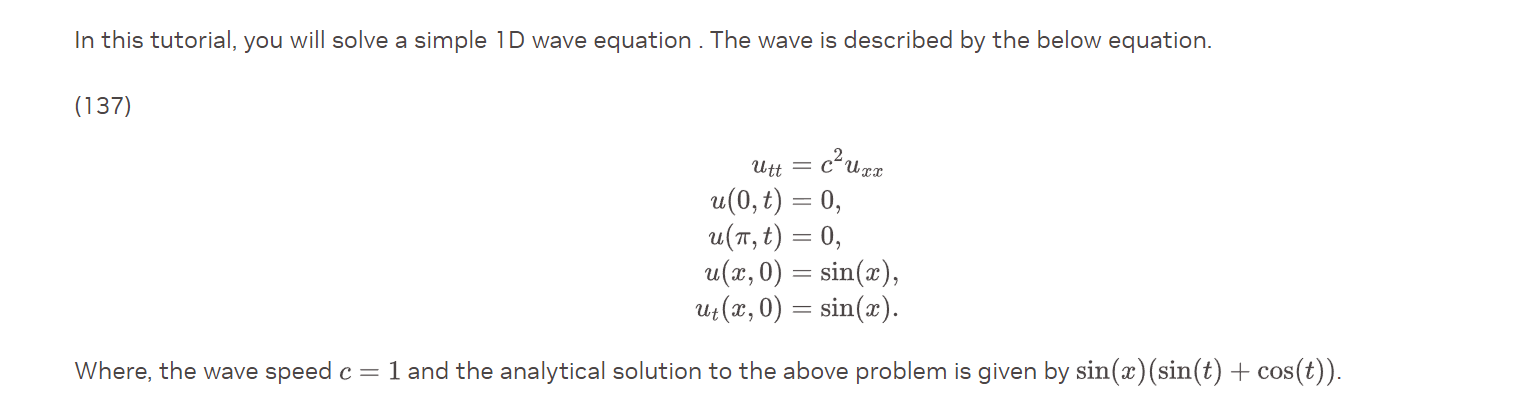

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 5.3 MB/s eta 0:00:00


In [102]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import deepxde as dde
import math
from itertools import product

In [103]:
t_min = 0
t_max = 2*np.pi

x_min = 0
x_max = np.pi

c = 1

In [104]:
def pde(x, y):  # wave equation
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)

    return dy_tt - c * c * dy_xx

In [105]:
geom = dde.geometry.Interval(x_min, x_max)
time = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, time)

In [106]:
def boundary_left(X, on_boundary):  # boundary x=0
    x, t = X
    is_on_boundary_left = on_boundary and np.isclose(x, x_min)

    return is_on_boundary_left

def boundary_right(X, on_boundary):  # boundary x=pi
    x, t = X
    is_on_boundary_right = on_boundary and np.isclose(x, x_max)

    return is_on_boundary_right

In [107]:
bc1 = dde.DirichletBC(geomtime, lambda x: 0, boundary_left)  #correct

bc2 = dde.DirichletBC(geomtime, lambda x: 0, boundary_right) #correct

bc3 = dde.DirichletBC(
    geomtime,
    lambda x: np.sin(x[:, 0:1]),
    lambda _, on_initial: on_initial,
)

bc4 = dde.NeumannBC(
    geomtime,
    lambda x: np.sin(x[:, 0:1]),
    lambda _, on_initial: on_initial,
)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)


In [108]:

# print("The training set is {}".format(data.train_x_all.T))

net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot uniform")  #the input layer has size 2, there are 4 hidden layers of size 50 and one output layer of size 1

#Activation function is tanh; the weights are initially chosen to be uniformly distributed according to Glorat distribution


model = dde.Model(data, net)

model.compile("adam", lr=0.001)

losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.064836 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.010313 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.98e-03, 9.92e-03, 4.57e-01, 2.11e-01, 7.34e-02]    [3.90e-03, 9.92e-03, 4.57e-01, 2.11e-01, 7.34e-02]    []  
1000      [1.35e-05, 5.76e-07, 1.44e-06, 9.66e-07, 9.29e-06]    [1.28e-05, 5.76e-07, 1.44e-06, 9.66e-07, 9.29e-06]    []  
2000      [4.95e-06, 3.55e-08, 3.00e-07, 1.54e-07, 2.98e-06]    [4.55e-06, 3.55e-08, 3.00e-07, 1.54e-07, 2.98e-06]    []  
3000      [1.68e-06, 2.59e-08, 1.07e-07, 6.25e-08, 1.16e-06]    [1.45e-06, 2.59e-08, 1.07e-07, 6.25e-08, 1.16e-06]    []  
4000      [8.41e-07, 1.89e-08, 2.84e-08, 2.32e-08, 4.40e-07]    [6.36e-07, 1.89e-08, 2.84e-08, 2.32e-08, 4.40e-07]    []  
5000      [5.44e-07, 1.08e-08, 5.22e-09, 8.27e-09, 1.62e-07]    [4.03e-07, 1.08e-08, 5.22e-09, 8.27e-09, 1.62e-07]    []  
6000      [4.06e-07, 1.42e-06, 1.34e-06, 1.38e-06, 9.79e-08]    [3.13e-07, 1.42e-06, 1

In [109]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 1.111448 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
20000     [2.13e-08, 7.74e-10, 1.45e-09, 1.08e-09, 1.48e-08]    [1.68e-08, 7.74e-10, 1.45e-09, 1.08e-09, 1.48e-08]    []  
20044     [2.13e-08, 7.73e-10, 1.45e-09, 1.08e-09, 1.48e-08]    [1.68e-08, 7.73e-10, 1.45e-09, 1.08e-09, 1.48e-08]    []  

Best model at step 20044:
  train loss: 3.95e-08
  test loss: 3.49e-08
  test metric: []

'train' took 8.410182 s



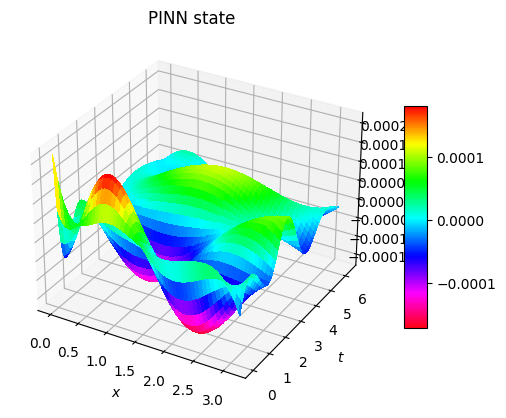

In [110]:
xx=np.linspace(x_min, x_max ,100)
tt=np.linspace(t_min , t_max, 200)

list_all_data=list(product(*[list(xx), list(tt)], repeat=1))

training_set=[(data.train_x_all.T[0][k], data.train_x_all.T[1][k]) for k in range(len(data.train_x_all.T[0]))]

def exact_function(x):
    return math.sin(x[0])*(math.sin(x[1]) + math.cos(x[1]))

X = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 200)

X_repeated = np.repeat(X, t.shape[0])
t_tiled = np.tile(t, X.shape[0])
XX = np.vstack((X_repeated, t_tiled)).T

state_predict = model.predict(XX).T
state_predict_M = state_predict.reshape((100, 200)).T

Xx, Tt = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(t_min, t_max, 200))

fig = plt.figure()  # plot of predicted state
ax = plt.axes(projection="3d")
surf = ax.plot_surface(
    Xx, Tt, state_predict_M, cmap="hsv_r", linewidth=0, antialiased=False
)

ax.set_title("PINN state ")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.colorbar(surf, shrink=0.6, aspect=10)

plt.show()

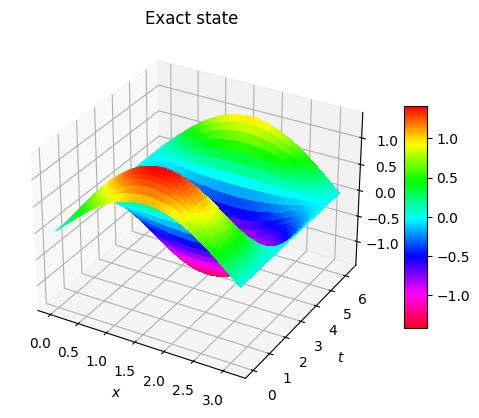

In [111]:
def explicit_state(x,t):
    return np.sin(x)*(np.sin(t) + np.cos(t))

state_exact = explicit_state(Xx, Tt)  # computation of exact state

fig = plt.figure()  # plot of exact state
ax = plt.axes(projection="3d")
surf2 = ax.plot_surface(
    Xx, Tt, state_exact, cmap="hsv_r", linewidth=0, antialiased=False
)

ax.set_title("Exact state ")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()

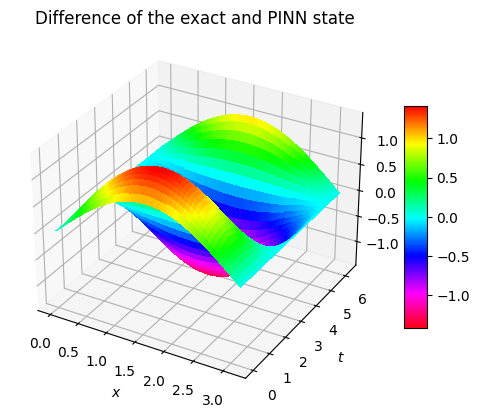

Text(0.5, 1.0, 'Training set')

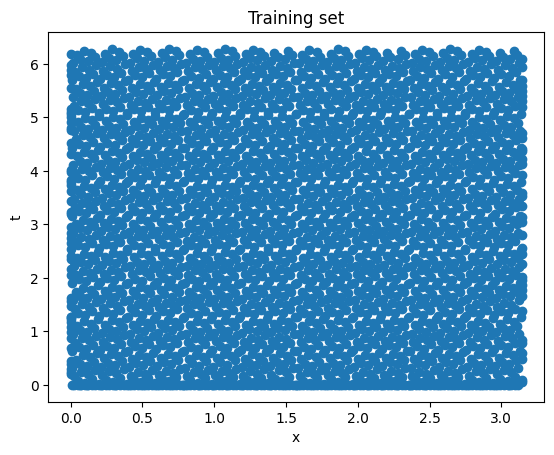

In [112]:
fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.plot_surface(
    Xx, Tt, state_exact-state_predict_M, cmap="hsv_r",
    linewidth=0, antialiased=False
)

ax.set_title("Difference of the exact and PINN state")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()


#Plot the training set and validation set
fig = plt.figure()

plt.plot(data.train_x_all.T[0], data.train_x_all.T[1],"o")
#plt.plot(validating_set.T[0], validating_set.T[1], "r", label="Validation set")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Training set")
#plt.legend()